**Exercise set 1: Olalla Nieto Faza**

*Problem 1.2. Solve approximately the Landau-Zener problem for the transition probability $p\left(\left|E_-\right> \rightarrow \left|E_+\right>  \right)$ by using the Magnus expansion up to third order. Consider the linear schedule $\varepsilon(t)=\nu t$ with $t \in (-100, +100)$ and compare it with the numerical solution to the time dependent problem examined in class.* 

First we get the code we used in class to numerically simulate the time evolution of the initial state under the Landau-Zener Hamiltonian and get the probability of a intersystem crossing.

$$
H(t)=-\frac{\Delta}{2}\sigma^x-\frac{\varepsilon(t)}{2}\sigma^z \quad ; \quad \varepsilon(t)=\nu t
$$

For each sweep rate v, the code:
1.  Constructs the time-dependent Hamiltonian.

2.  Simulates the time evolution of the initial state $\left|\psi_0\right>$.

3.  Projects the state onto the instantaneous eigenstates in order to get the transition probabilities.

4.  Plots the transition probability over time, the analytical Landau-Zener probability $P_{LZ}=e^{−2\pi\delta}$ and the driving function $\varepsilon(t)$ on a second axis.

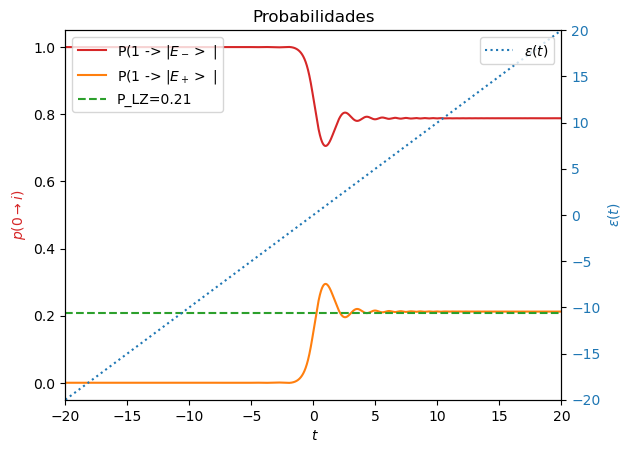

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt


'Let us define the Evolution Operator'
def Uev(t,H):
    U = la.expm(-1j*t*H)
    return U

'Let us define the evolved state of a time dependent Hamiltonian    '
def state_psi(t,psi0,H):
    assert len(psi0) == H.shape[0]
    return np.dot(Uev(t,H),psi0)


'estado inicial a t = - \\infty  es |1>'
psi0 = [0, 1]             #  INITIAL STATE

'listado de tiempos de evolución'
tmin = -20
tmax = 20
steps = 50000
tlist = np.linspace(tmin, tmax, steps)    # a NumPy array of steps evenly spaced time points between tmin and tmax
v = 1    #  SWEEP RATE
schedule = tlist * v
dt = tlist[1] - tlist[0]

'listado de Hamiltonianos instantáneos'
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
Delta = 1    # DELTA
Hlist = [-Delta / 2 * sigma_x - eps_k / 2 * sigma_z for eps_k in schedule]

'listado de vectores |E-(t)> instantáneos de menor autovalor'
Eigenvectors = [la.eigh(H)[1] for H in Hlist]      # diagonalize Hamiltonians and get eigenvectors
psi_t = np.empty((len(tlist), 2), dtype=complex)
psi_t[0] = psi0

'listado de estados a cada tiempo |psi(t)>'
for k in range(len(tlist)-1):
    psi_t[k + 1] = state_psi(dt, psi_t[k], Hlist[k])   # here we evolve psi_t[k] to psi_t[k+1] exponentiating H[k]
    #print('t = ', tlist[k])
    #print(psi_t[k + 1])
    #print('')


'Landau-Zenner asymptotic  transition probability' 
P_LZ = np.exp(-2*np.pi*Delta**2/(4*v)) 

'list of transition probabilities of the state psi(t) to each on of the instantaneous eigenstates'
pmlist = [np.abs(np.dot(psi_t[i],Eigenvectors[i][0]))**2  for i in range(len(tlist))]  # |<E-|psi>|^2
pplist = [np.abs(np.dot(psi_t[i],Eigenvectors[i][1]))**2  for i in range(len(tlist))]  # |<E+|psi>|^2

'plot of the transition probabilities'
fig, ax1 = plt.subplots()
ax1.set_title(r'Probabilidades')
ax1.set_xlabel(r' $t$ ')
ax1.set_ylabel(r'$p(0 \rightarrow i)$', color='tab:red')
color = 'tab:red'
ax1.plot(tlist, pmlist, color='tab:red', label='P(1 -> |$E_->$ |')
ax1.plot(tlist, pplist, color='tab:orange', label='P(1 -> |$ E_+>$ |')
ax1.axhline(y=P_LZ, color='tab:green', linestyle='--', label=f'P_LZ={P_LZ:.2f}')
ax1.legend(loc='upper left')
ax1.set_xlim(tmin,tmax)
#ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.plot(tlist, schedule, color='tab:blue', linestyle='dotted', label=r'$\varepsilon(t)$')
ax2.legend(loc='upper right')
ax2.set_ylabel(r'$\varepsilon(t)$', color='tab:blue')
ax2.set_ylim(tmin, tmax)
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.show()





The Magnus expansion approximates the time-evolution operator ($\mathcal{T}$ is the time-ordering operator) with an exponential of a series of commutators involving the time-dependent Hamiltonian $H(t)$. Its main advantage is that unitarity is guaranteed at every truncation order.

$$
U(t, t_0)=\mathcal{T}\exp\left( -\frac{i}{\hbar}\int_{0}^t H(t')dt' \right) = 
\exp\left( -i\Omega(t,t_0)  \right)
$$

where

$$
\Omega(t,t_0)=\sum_{n=0}^{\infty}\lambda^n\Omega^{(n)}(t,t_0)
$$


If we truncate the expansion at the third order, we have that:
$$
\Omega(t,t_0)=\Omega^{(1)}(t,t_0)+\Omega^{(2)}(t,t_0)+\Omega^{(3)}(t,t_0)
$$

$$
\Omega^{(1)}(t,t_0)=\frac{1}{\hbar}\int_{t_0}^{t}H(t_1)dt_1
$$

$$
\Omega^{(2)}(t,t_0)=-\frac{i}{\hbar^2}\int_{t_0}^{t}dt_1\int_{t_0}^{t_1} [H(t_1),H(t_2)]dt_2
$$

$$
\Omega^{(3)}(t,t_0)=-\frac{1}{3!\hbar^3}\int_{t_0}^{t}dt_1\int_{t_0}^{t_1}dt_2\int_{t_0}^{t_2} \left( \left[  H(t_1), [H(t_2),H(t_3)]  \right] + \left[ [H(t_1),H(t_2)], H(t_3) \right] \right) dt_3
$$

Now we generate the code to implement the Magnus expansion:

In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# We define some constants
#--------------------------------------------------------
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
hbar = 1.0

    # Hamiltonian parameters
    #--------------------------
Delta=1.0    
v=0.2        
     # time boundaries
#--------------------------
t0=-2       
t1=2
steps=100
#--------------------------------------------------------


# We define the Landau-Zener Hamiltonian
#--------------------------------------------------------
def H_LZ(t, Delta, v):
    epsilon = v * t
    return -Delta / 2 * sigma_x - epsilon / 2 * sigma_z

# Here we define functions to calculate the Magnus expansion terms (just the integrals)
#--------------------------------------------------------
def omega1(t0, t1, steps, *args):
    dim = H_LZ(t0, *args).shape[0]
    dt = (t1 - t0) / steps
    result = np.zeros((dim, dim), dtype=complex)   # we create a zero matrix to store the result of the integral
    for i in range(steps):
        t = t0 + i * dt
        result += H_LZ(t, *args) * dt
    return result

def omega2( t0, t1, steps, *args):
    dt = (t1 - t0) / steps
    dim = H_LZ(t0, *args).shape[0]
    result = np.zeros((dim, dim), dtype=complex)
    for i in range(steps):     # loop over t1
        t1_temp = t0 + i * dt
        H1 = H_LZ(t1_temp, *args)
        for j in range(i):     # loop over t2
            t2_temp = t0 + j * dt
            H2 = H_LZ(t2_temp, *args)
            comm = np.matmul(H1, H2) - np.matmul(H2, H1)   # [H1,H2]
            result += comm * dt**2
            #result_inner += comm * dt
       # result_outer += result_inner*dt
   # return result_outer
    return result

def omega3(t0, t1, steps, *args):
    dt = (t1 - t0) / steps
    dim = H_LZ(t0, *args).shape[0]
    result = np.zeros((dim, dim), dtype=complex)
    for i in range(steps):
        t1_temp = t0 + i * dt
        H1 = H_LZ(t1_temp, *args)
        for j in range(i):
            t2_temp = t0 + j * dt
            H2 = H_LZ(t2_temp, *args)
            for k in range(j):
                t3_temp = t0 + k * dt
                H3 = H_LZ(t3_temp, *args)
                comm1 = np.matmul(H1 , np.matmul(H2, H3) - np.matmul(H3, H2))
                comm2 = np.matmul( np.matmul(H1 , H2) - np.matmul(H2 , H1) ,  H3)
                result += (comm1 + comm2) * dt**3
                #result_inner += (comm1 + comm2) * dt
            #result_middle +=result_inner *dt
        #result_outer += result_middle *dt
    #return result_outer
    return result

# We calculate the evolution through the Magnus expansion
#--------------------------------------------------------
def magnus_transition_probability(Delta, v, t0, t1, steps=100):
    
    omega =       1/hbar*omega1(t0, t1, steps, Delta, v) \
           -1j/(hbar**2)*omega2(t0, t1, steps, Delta, v) \
          -1/(6*hbar**3)*omega3(t0, t1, steps, Delta, v)

    U = la.expm(-1j * omega )    # system evolution in the Magnus expansion

    eigval_t0, eigvecs_t0 = la.eigh(H_LZ(t0, Delta, v))    # eigenvalues and eigenstates at t0 and t1
    eigval_t1, eigvecs_t1 = la.eigh(H_LZ(t1, Delta, v))

    psi_t0 = eigvecs_t0[:, 0]  # ground state at t0 (the first state is the ground state, with the lowest eigenvalue, when using eigh, for Hermitian matrices)
    psi_t1 = eigvecs_t1[:, 1]  # excited state at t1   

    psi_t0=[0,1]   ####### If we want to start with [0,1] (ground state at -infinity) instead of the actual ground state at t0 calculated from the Hamiltonian
    
    psi_evolved = np.matmul(U , psi_t0)   # evolution of the initial state psi_t0
    
    P = np.abs(np.vdot(psi_t1, psi_evolved))**2    # the probability of switching the state is the proyection of the evolved state onto the excited state at t1 
    return P

# We obtain probabilities
#-------------------------------------------------

P_example = magnus_transition_probability(Delta=1.0, v=0.8, t0=-2, t1=2, steps=100)
#P_example = magnus_transition_probability(Delta, v=1, t0, t1, steps)
print(f"Transition probability: {P_example:.6f}")






Transition probability: 0.242991


After this example, we run the program over different times to plot the transition probabilities.

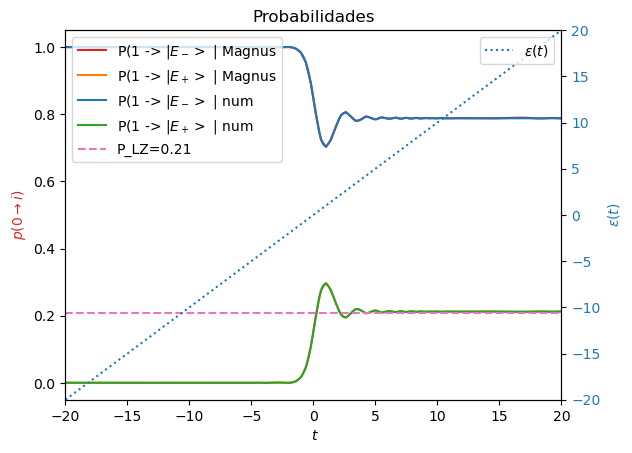

In [3]:
'estado inicial a t = - \\infty  es |1>'
psi0 = [0, 1]             #  INITIAL STATE


'listado de tiempos de evolución'
tmin = -20
tmax = 20
steps = 100    # smaller number of steps IT IS COSTLY!!!!
tlist_magnus = np.linspace(tmin, tmax, steps)    # a NumPy array of steps evenly spaced time points between tmin and tmax
v = 1     #  SWEEP RATE
schedule = tlist_magnus * v
dt = tlist_magnus[1] - tlist_magnus[0]

'listado de Hamiltonianos instantáneos'
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
Delta = 1    # DELTA
Hlist = [-Delta / 2 * sigma_x - eps_k / 2 * sigma_z for eps_k in schedule]

'listado de vectores |E-(t)> instantáneos de menor autovalor'
Eigenvectors = [la.eigh(H)[1] for H in Hlist]      # diagonalize Hamiltonians and get eigenvectors
psi_t = np.empty((len(tlist_magnus), 2), dtype=complex)
psi_t[0] = psi0


def magnus_evolve(psi_t0, Delta, v, t0, t1, steps):
    # here steps means the steps in the integrations
    
    omega =       1/hbar*omega1(t0, t1, steps, Delta, v) \
           -1j/(hbar**2)*omega2(t0, t1, steps, Delta, v) \
          -1/(6*hbar**3)*omega3(t0, t1, steps, Delta, v)

    U = la.expm(-1j * omega )    # system evolution in the Magnus expansion

    psi_evolved = np.matmul(U , psi_t0)   # evolution of the initial state psi_t0 
    
   # P = np.abs(np.vdot(psi_t1, psi_evolved))**2    # the probability of switching the state is the proyection of the evolved state onto the excited state at t1 
    return psi_evolved

'listado de estados a cada tiempo |psi(t)>'
for k in range(len(tlist_magnus)-1):
    psi_t[k + 1] = magnus_evolve(psi_t[k], Delta,v, tlist_magnus[k],tlist_magnus[k+1], steps=200)
    #print('t = ', tlist[k])
    #print(psi_t[k + 1])
    #print('')


'Landau-Zenner asymptotic  transition probability' 
P_LZ = np.exp(-2*np.pi*Delta**2/(4*v)) 

'list of transition probabilities of the state psi(t) to each on of the instantaneous eigenstates'
pmlist_magnus = [np.abs(np.dot(psi_t[i],Eigenvectors[i][0]))**2  for i in range(len(tlist_magnus))]  # |<E-|psi>|^2
pplist_magnus = [np.abs(np.dot(psi_t[i],Eigenvectors[i][1]))**2  for i in range(len(tlist_magnus))]  # |<E+|psi>|^2



'plot of the transition probabilities'
fig, ax1 = plt.subplots()
ax1.set_title(r'Probabilidades')
ax1.set_xlabel(r' $t$ ')
ax1.set_ylabel(r'$p(0 \rightarrow i)$', color='tab:red')
color = 'tab:red'
ax1.plot(tlist_magnus, pmlist_magnus, color='tab:red', label='P(1 -> |$E_->$ | Magnus')
ax1.plot(tlist_magnus, pplist_magnus, color='tab:orange', label='P(1 -> |$ E_+>$ | Magnus')
ax1.plot(tlist, pmlist, color='tab:blue', label='P(1 -> |$E_->$ | num' )
ax1.plot(tlist, pplist, color='tab:green', label='P(1 -> |$ E_+>$ | num')
ax1.axhline(y=P_LZ, color='tab:pink', linestyle='--', label=f'P_LZ={P_LZ:.2f}')
ax1.legend(loc='upper left')
ax1.set_xlim(tmin,tmax)
#ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.plot(tlist_magnus, schedule, color='tab:blue', linestyle='dotted', label=r'$\varepsilon(t)$')
ax2.legend(loc='upper right')
ax2.set_ylabel(r'$\varepsilon(t)$', color='tab:blue')
ax2.set_ylim(tmin, tmax)
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.show()


The probability for the transition from $\left|E_-\right> \rightarrow \left|E_+\right>  $ is 
$$
P_{-\rightarrow +} = \left| \left<E_+(t_1)\right|U(t_1,t_0)\left|E_-(t_0) \right>   \right|^2
$$

When using for the Magnus expansion 100 time steps and a decent number for the steps in the integrals (I chose 200), the curves are superimposable. If either of these numbers is reduced, the curves corresponding to the Magnus expansion are not as smooth, but they reproduce quite well the numerical results. I've just used a time evolution between -20 and 20, because the calculation is rather costly and takes forever in my computer to run for longer times.